In [3]:
import copy
from copyreg import pickle
from pathlib import Path
import warnings
from xmlrpc.client import DateTime

import stock_indicators as sa
import lightning.pytorch as pl
from etfpy import load_etf
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from etfpy import ETF, load_etf, get_available_etfs_list
from prometheus_client.samples import Timestamp
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

C:\Users\valky\DataspellProjects\HF_Thesis\venv\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [37]:
pos_desc = []
data = {}

In [4]:
porftolio_alloc = pd.read_csv('porftolio_alloc.csv', sep=",")
porftolio_alloc

,ISIN,Position Description,Conservative,Moderate Conservative,Moderate,Moderate Aggressive,Aggressive
0,IE0005042456,ISHARES CORE FTSE 100 UCITS ETF GBP (DIST),-,-,-,-,1.50%
1,IE000T9EOCL3,ISHARES MSCI WORLD SMALL CAP ESG ENHANCED UCIT...,1.00%,1.50%,2.00%,2.50%,3.50%
2,IE00B3ZW0K18,ISHARES S&P 500 EUR HEDGED UCITS ETF (ACC),4.00%,8.50%,11.50%,13.50%,18.00%
3,IE00B52MJY50,ISHARES CORE MSCI PACIFIC EX-JAPAN UCITS ETF U...,-,-,1.00%,1.00%,1.00%
4,IE00B52VJ196,ISHARES MSCI EUROPE SRI UCITS ETF EUR (ACC),-,1.00%,-,-,-
5,IE00BFNM3G45,ISHARES MSCI USA ESG SCREENED UCITS ETF USD (ACC),-,-,-,6.50%,12.50%
6,IE00BHZPJ452,ISHARES MSCI JAPAN ESG ENHANCED UCITS ETF USD ...,1.50%,3.00%,4.00%,6.00%,7.50%
7,IE00BHZPJ783,ISHARES MSCI EUROPE ESG ENHANCED UCITS ETF EUR...,-,-,2.50%,3.00%,7.00%
8,IE00BHZPJ908,ISHARES MSCI USA ESG ENHANCED UCITS ETF USD (ACC),6.00%,12.50%,16.50%,18.00%,18.00%
9,IE00BYYHSM20,ISHARES MSCI EUROPE QUALITY DIVIDEND ESG UCITS...,2.00%,3.50%,3.50%,6.00%,4.50%


In [5]:
chanes_in_pa = pd.read_csv('chanes_in_pa.csv')
chanes_in_pa

,ISIN,Position Description,Conservative,Moderate Conservative,Moderate,Moderate Aggressive,Aggressive
0,IE0005042456,ISHARES CORE FTSE 100 UCITS ETF GBP (DIST),-,-,-,-,-
1,IE000T9EOCL3,ISHARES MSCI WORLD SMALL CAP ESG ENHANCED UCIT...,1.00%,1.50%,2.00%,2.50%,3.50%
2,IE00B1XNHC34,ISHARES GLOBAL CLEAN ENERGY UCITS ETF USD (DIST),-,-,-1.00%,-1.00%,-1.50%
3,IE00B3ZW0K18,ISHARES S&P 500 EUR HEDGED UCITS ETF (ACC),-,-,-,-,-
4,IE00B52MJY50,ISHARES CORE MSCI PACIFIC EX-JAPAN UCITS ETF U...,-,-,-,-,-
5,IE00B52VJ196,ISHARES MSCI EUROPE SRI UCITS ETF EUR (ACC),-,-0.50%,-,-,-
6,IE00BFNM3G45,ISHARES MSCI USA ESG SCREENED UCITS ETF USD (ACC),-,-,-,-,-
7,IE00BHZPJ015,ISHARES MSCI EMU ESG ENHANCED UCITS ETF EUR (ACC),-,-,-,-2.50%,-2.50%
8,IE00BHZPJ452,ISHARES MSCI JAPAN ESG ENHANCED UCITS ETF USD ...,-0.50%,-0.50%,-1.00%,-1.00%,-1.00%
9,IE00BHZPJ783,ISHARES MSCI EUROPE ESG ENHANCED UCITS ETF EUR...,-,-,-,-,-


In [6]:
import os
prices_of_funds = {}
for file in os.listdir("ISINS"):
    if file.endswith(".csv"):
        nu_file = file.replace(".csv","")
        df = pd.read_csv(f"ISINS/{file}")
        prices_of_funds[nu_file] = df
        prices_of_funds[nu_file].index = prices_of_funds[nu_file]["date"]
        del prices_of_funds[nu_file]["date"]
        prices_of_funds[nu_file]["daily_relative"] = prices_of_funds[nu_file]["quote"].pct_change() * 100
        prices_of_funds[nu_file]['continuous_roi'] = (np.log(prices_of_funds[nu_file]["quote"] / prices_of_funds[nu_file]["quote"].shift(1)))
        prices_of_funds[nu_file].fillna(0, inplace=True)

In [7]:
import yfinance as yf
import os
files = os.listdir("ISINS")
files = [file.replace(".csv", "") for file in files]

funds=[]
for fund in files:
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2006-01-01", end="2024-01-01")))
    funds.append(a)
    
for fund in funds:
    if 'Dividends' in fund.columns:
        fund.drop(['Dividends'], axis=1, inplace=True)
    if 'Stock Splits' in fund.columns:
        fund.drop(['Stock Splits'], axis=1, inplace=True)
    if 'Capital Gains' in fund.columns:
        fund.drop(["Capital Gains"], axis=1, inplace=True)
    fund["date"]=fund.index
    fund.drop('date', axis=1, inplace=True)

[DEBUG] yfinance 2024-11-28 17:25:38,112 wrapper:101 - Entering history()
[DEBUG] peewee 2024-11-28 17:25:38,133 execute_sql:3319 - ('CREATE TABLE IF NOT EXISTS "_kv" ("key" VARCHAR(255) NOT NULL PRIMARY KEY, "value" VARCHAR(255)) WITHOUT ROWID', [])
[DEBUG] peewee 2024-11-28 17:25:38,134 execute_sql:3319 - ('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['ISF.L', 1, 0])
[DEBUG] yfinance 2024-11-28 17:25:40,636 wrapper:101 -  Entering history()
[DEBUG] yfinance 2024-11-28 17:25:40,648 history:161 - ISF.L: Yahoo GET parameters: {'period1': '2006-01-01 00:00:00+00:00', 'period2': '2024-01-01 00:00:00+00:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
[DEBUG] yfinance 2024-11-28 17:25:40,648 wrapper:101 -   Entering get()
[DEBUG] yfinance 2024-11-28 17:25:40,649 wrapper:101 -    Entering _make_request()
[DEBUG] yfinance 2024-11-28 17:25:40,649 _make_request:346 - url=https://query2.finance.yahoo.com/v8/fin

In [10]:
print(funds[0])

                            Open   High    Low  Close    Volume
Date                                                           
2009-01-02 00:00:00+00:00 444.23 456.43 442.49 456.43   3492665
2009-01-05 00:00:00+00:00 457.92 460.16 451.70 458.17   8843876
2009-01-06 00:00:00+00:00 459.91 467.88 455.93 463.40  10981299
2009-01-07 00:00:00+00:00 464.89 464.89 447.72 449.46  10084698
2009-01-08 00:00:00+00:00 443.74 451.45 441.00 450.21   7024435
...                          ...    ...    ...    ...       ...
2023-12-21 00:00:00+00:00 748.37 751.07 746.57 749.07   2914459
2023-12-22 00:00:00+00:00 747.77 775.26 745.37 749.77   2511040
2023-12-27 00:00:00+00:00 753.07 755.47 749.77 751.97   2040865
2023-12-28 00:00:00+00:00 752.37 754.27 725.68 751.67   4989178
2023-12-29 00:00:00+00:00 751.97 755.17 749.27 752.87   3395009

[3787 rows x 5 columns]


In [112]:
import datetime
from stock_indicators import Quote
fund_smass = {}

for idx, fund in enumerate(funds):
    quotes_list = [
        Quote(d,o,h,l,c,v) for d,o,h,l,c,v in zip(fund['date'], fund['Open'], fund['High'], fund['Low'], fund['Close'], fund['Volume'])
    ]
    fund_smass[files[idx]] = sa.indicators.get_sma(quotes_list, 30)
    for s in fund_smass[files[idx]]:
        pass
        #gave up goodnight

In [8]:
from stock_indicators import Quote
f = funds[0]

FIXING DATASET

In [9]:
full_date_range = pd.date_range(start=f.index.min(), end=f.index.max(), freq="D")
f = f.reindex(full_date_range)

In [10]:
# backfill missing data
f.fillna(method="bfill", inplace=True)

C:\Users\valky\AppData\Local\Temp\ipykernel_7196\2953939639.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  f.fillna(method="bfill", inplace=True)


In [11]:
f.index = pd.to_datetime(f.index)  # ensure index is datetime if not already
f["time_idx"] = (f.index - f.index.min()).days.astype(int)  # convert to numeric index
f["group_id"] = 0  # replace with actual group identifier MEGA USEFUL !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [12]:
training_cutoff_date = pd.to_datetime("2023-12-22 00:00:00").tz_localize("Europe/London")

if training_cutoff_date not in f.index:
    training_cutoff_date = f.index[f.index.get_loc(training_cutoff_date, method="nearest")]

training_cutoff_idx = f.loc[training_cutoff_date, "time_idx"]
print("Training cutoff date:", training_cutoff_date)
print("Training cutoff index:", training_cutoff_idx)

Training cutoff date: 2023-12-22 00:00:00+00:00
Training cutoff index: 5467


In [13]:
f = f.groupby("time_idx").mean().reset_index() # idk why but its necessary
f["date"] = pd.to_datetime("2009-01-02") + pd.to_timedelta(f["time_idx"], unit="D")
f.set_index("date", inplace=True)

In [14]:
print(f["time_idx"].diff().value_counts())  # all differences should be 1

time_idx
1.00    5444
2.00      15
Name: count, dtype: int64


In [15]:
f_orig = f.drop(["time_idx", "group_id"], axis=1)

TECHNICAL INDICATORS

In [16]:
from stock_indicators import Quote
f_orig.index = pd.to_datetime(f_orig.index)  # Ensure datetime index

quotes_for_f = [
    Quote(
        date=row.Index,  
        open=row.Open,
        high=row.High,
        low=row.Low,
        close=row.Close,
        volume=row.Volume
    )
    for row in f_orig.itertuples()
]

In [17]:
ema_for_f = sa.indicators.get_ema(quotes_for_f, 9)

In [138]:
vwap_for_f = sa.indicators.get_vwap(quotes=quotes_for_f)

In [139]:
macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)

In [159]:
cutoff_date = datetime.datetime(2009, 1, 28)
macd_for_f = [result for result in macd_for_f if result.date > cutoff_date]
vwap_for_f = [result for result in vwap_for_f if result.date > cutoff_date]

In [152]:
valid_macd_for_f = [
    (result.date, result.macd, result.signal, result.histogram)
    for result in macd_for_f
    if result.macd is not None and result.signal is not None and result.histogram is not None
]
dates, macd_values, signal_values, histogram_values = zip(*valid_macd_for_f)

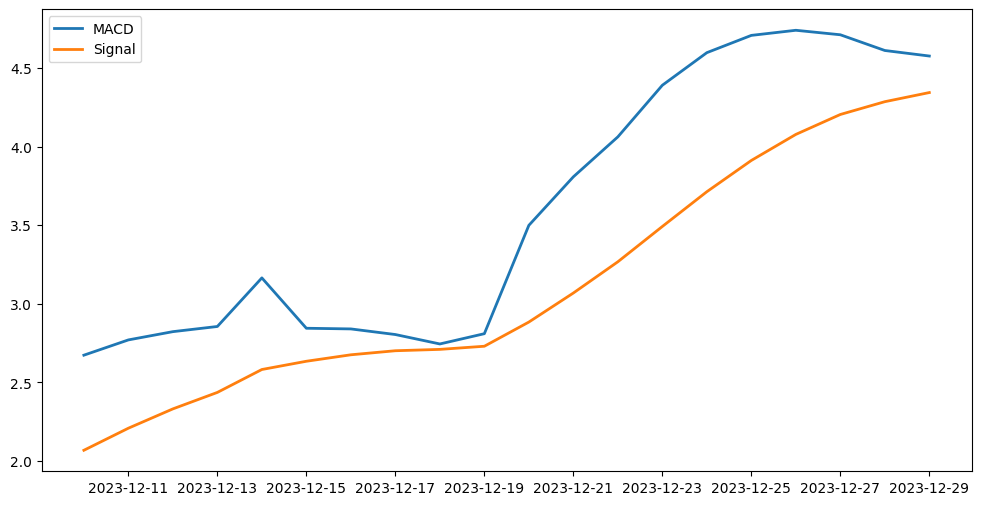

In [164]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dates[-20:], macd_values[-20:], label='MACD', linewidth=2)
plt.plot(dates[-20:], signal_values[-20:], label='Signal', linewidth=2)
plt.legend(loc='best')

In [160]:
valid_vwap_for_f = [
    (result.date, result.vwap)
    for result in vwap_for_f
    if result.vwap is not None
]
dates, vwap_values = zip(*valid_vwap_for_f)

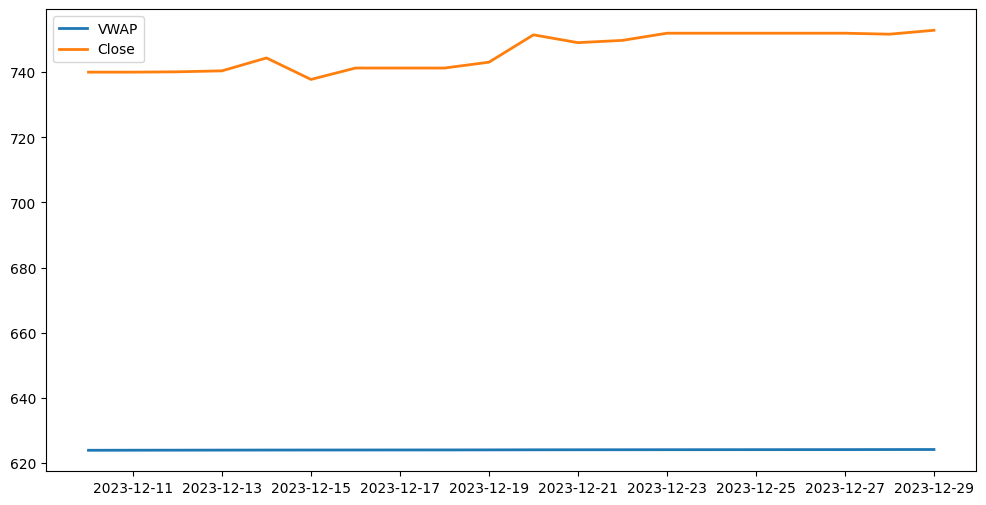

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dates[-20:], vwap_values[-20:], label='VWAP', linewidth=2)
plt.plot(dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
plt.legend(loc='best')

In [19]:
valid_ema_for_f = [
    (result.date, result.ema)
    for result in ema_for_f
    if result.ema is not None
]
dates, ema_values = zip(*valid_ema_for_f)

[DEBUG] matplotlib.pyplot 2024-11-28 17:26:03,455 switch_backend:487 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG] matplotlib.pyplot 2024-11-28 17:26:03,456 switch_backend:487 - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG] matplotlib.font_manager 2024-11-28 17:26:03,459 _findfont_cached:1416 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[DEBUG] matplotlib.font_manager 2024-11-28 17:26:03,460 _findfont_cached:1428 - findfont: score(FontEntry(fname='C:\\Users\\valky\\DataspellProjects\\HF_Thesis\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG] matplotlib.font_manager 2024-11-28 17:26:03,461 _findfont_cached:1428 - findfont: score(FontEntry(fname='C:\\Users\\valky\\DataspellProjects\\HF_Thesis\\venv\\Lib

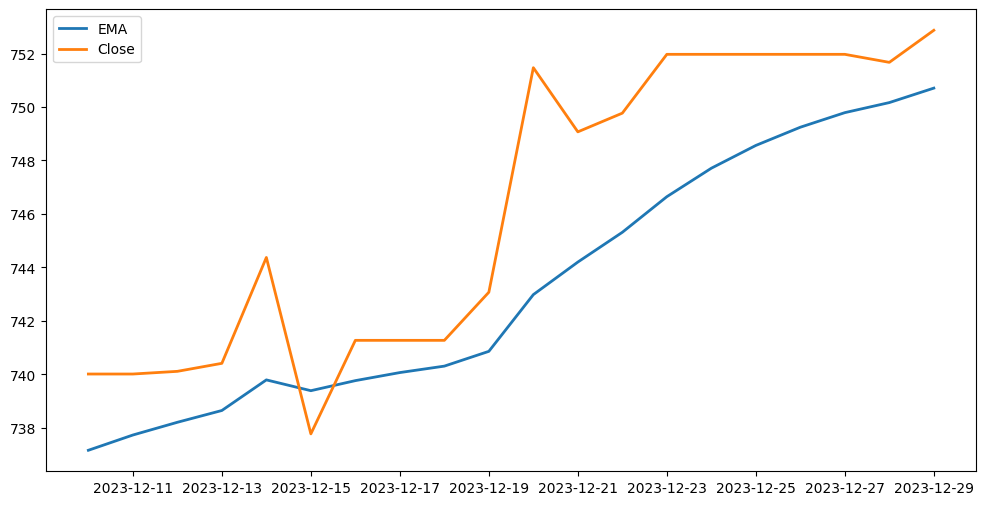

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dates[-20:], ema_values[-20:], label='EMA', linewidth=2)
plt.plot(dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
plt.legend(loc='best')

TORCH

In [ ]:
import warnings
warnings.filterwarnings("ignore")

max_prediction_length = 7
max_encoder_length = 365

In [16]:
training = TimeSeriesDataSet(
    f[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
    time_idx="time_idx",             # Sequential time index
    target="Close",                  # Target variable
    group_ids=["group_id"],          # Group identifier
    min_encoder_length=max_encoder_length // 2,  # Minimum input sequence length
    max_encoder_length=max_encoder_length,       # Maximum input sequence length
    min_prediction_length=1,                     # Minimum forecast length
    max_prediction_length=max_prediction_length, # Maximum forecast length (31 for December)
    static_reals=[],                              # No static real variables
    time_varying_known_reals=["time_idx", "Open", "High", "Low", "Volume"],  # Known inputs
    time_varying_unknown_reals=["Close"],         # Target variable
    target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
    add_relative_time_idx=True,                  # Add relative time index
    add_target_scales=True,                      # Scale the target variable
    add_encoder_length=True,                     # Include encoder length feature
    allow_missing_timesteps=True,               # Ensure no missing steps
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    f,
    predict=True,
    stop_randomization=True                             # Ensures no randomization in validation dataset
)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [17]:
for batch in train_dataloader:
    batch_data, batch_target = batch  # Or just unpack `batch_data` if targets are not needed
    print(batch_data["encoder_cont"].shape, batch_data["decoder_cont"].shape)
    break

torch.Size([128, 365, 10]) torch.Size([128, 7, 10])


In [18]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,              # Learning rate
    hidden_size=16,                  # Model hidden size
    attention_head_size=1,           # Number of attention heads
    dropout=0.1,                     # Dropout rate
    hidden_continuous_size=8,        # Hidden size for continuous variables
    output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
    loss=QuantileLoss(),             # Loss function
    log_interval=10,                 # Log every 10 batches
    reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
)

In [19]:
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Number of parameters in network: 24.0k


In [37]:
from lightning.pytorch.callbacks import ModelCheckpoint
import lightning.pytorch as pl
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/", 
    filename="tft-model-{epoch:02d}-{val_loss:.2f}",  
    save_top_k=1,  
    monitor="val_loss",  # 
    mode="min",  # minimize validation loss
)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    # logger=logger,
    max_epochs=30,               
    accelerator='cuda',
    devices="auto",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_logger, checkpoint_callback],
)

trainer.fit(tft, train_dataloader, val_dataloader)

[INFO] pytorch_lightning.utilities.rank_zero 2024-11-27 23:33:03,354 _info:63 - GPU available: True (cuda), used: True
[INFO] pytorch_lightning.utilities.rank_zero 2024-11-27 23:33:03,355 _info:63 - TPU available: False, using: 0 TPU cores
[INFO] pytorch_lightning.utilities.rank_zero 2024-11-27 23:33:03,355 _info:63 - HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

[DEBUG] fsspec.local 2024-11-27 23:33:03,434 __init__:351 - open file: C:/Users/valky/DataspellProjects/HF_Thesis/lightning_logs/version_14/hparams.yaml
Epoch 0: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s, v_num=14, train_loss_step=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 42/42 [00:10<00:00,  3.87it/s, v_num=14, train_loss_step=1.130, val_loss=2.820, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 42/42 [00:10<00:00,  3.85it/s, v_num=14, train_loss_step=1.170, val_loss=2.720, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 42/42 [00:10<00:00,  3.82it/s, v_num=14, train_loss_step=1.310, val_loss=2.730, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 42/42 [00:10<00:00,  3.82it/s, v_num=14, train_loss_step=1.280, val_loss=2.830, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5

In [38]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DEBUG] fsspec.local 2024-11-27 23:35:48,621 __init__:351 - open file: C:/Users/valky/DataspellProjects/HF_Thesis/lightning_logs/version_15/hparams.yaml


In [39]:
predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()

In [40]:
date_range = pd.date_range(start="2023-12-23", end="2023-12-29")

In [41]:
print("Date range length:", len(date_range))  # Should be 7 (December 22–29)
print("Predicted median shape:", predicted_median_np.shape)  # Should match

Date range length: 7
Predicted median shape: (7,)


In [42]:
assert len(date_range) == len(predicted_median_np), "Mismatch between date range and predictions"

In [43]:
actual_values = f["Close"]["2023-12-23":]

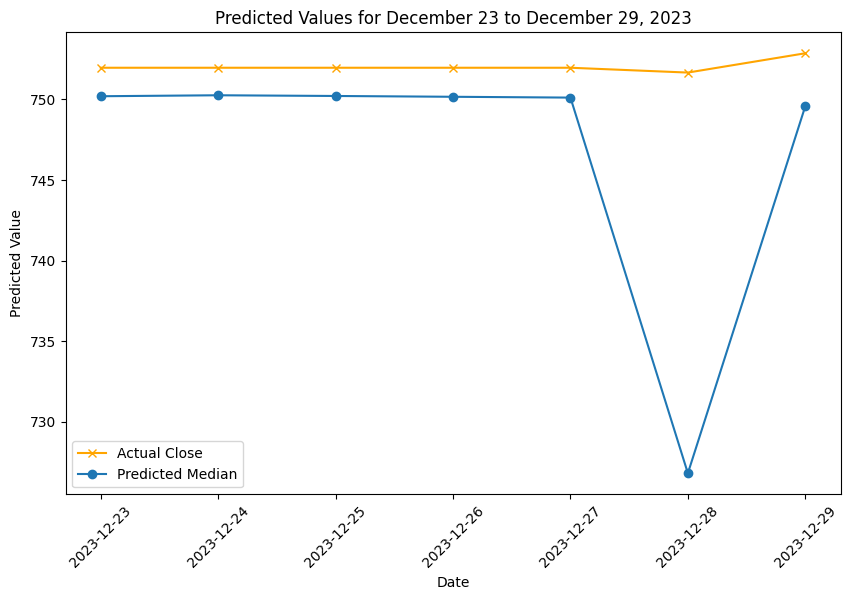

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
plt.plot(date_range, predicted_median_np, marker="o", label="Predicted Median")
plt.title("Predicted Values for December 23 to December 29, 2023")
plt.xlabel("Date")
plt.ylabel("Predicted Value")
plt.xticks(rotation=45)
plt.legend()
plt.show()